## colab setting ,read file and import module

In [63]:
#!pip install google.colab #如未安裝取消註解後執行
import os
from google.colab import drive
drive.mount('/content/my_drive')

Drive already mounted at /content/my_drive; to attempt to forcibly remount, call drive.mount("/content/my_drive", force_remount=True).


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_for_NNs_non_time_feature.csv'
df = pd.read_csv(file_path, encoding='utf-8')

In [65]:
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Reshape, Multiply, GRU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

## 預處理一下資料

In [66]:
# df.info(max_cols=129)

In [67]:
# time_part_index1 = df.iloc[:,15:35].columns
# time_part_index2 = df.iloc[:,72:75].columns

In [68]:
# time_part_index = list(time_part_index1) + list(time_part_index2)

In [69]:
# delete_time_df = df.drop(time_part_index,axis=1)

In [70]:
# delete_time_df.info(max_cols=106)

In [71]:
# delete_time_df.columns[50:]

In [72]:
# new_index = ['year_month_for_combine', 'new_per_ping',
# 		'main_building_ratio', 'building_age',
#        'number_of_land', 'number_of_building', 'number_of_parking_space',
#         'total_area_ping', 'total_floors',
#        'target_floor', 'transaction_floors', 'bedrooms', 'living_rooms',
#        'bathrooms',
#         'Public_Activity_Space_under_250_m',
#        'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
#        'School_under_250_m', 'Kindergarten_under_250_m',
#        'Convenience_Store_under_250_m', 'Bank_under_250_m',
#        'Clinic_under_250_m', 'Pharmacy_under_250_m',
#        'acc_Public_Activity_Space_under_500m',
#        'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
#        'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
#        'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
#        'acc_School_under_500m', 'acc_School_under_750m',
#        'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
#        'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
#        'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
#        'acc_Daycare_Center_under_750m', 'acc_Convenience_Store_under_500m',
#        'acc_Convenience_Store_under_750m', 'acc_Bank_under_500m',
#        'acc_Bank_under_750m', 'acc_Police_Station_under_750m',
#        'acc_Clinic_under_500m', 'acc_Clinic_under_750m',
#        'acc_Pharmacy_under_500m', 'acc_Pharmacy_under_750m', 'acc_Medical_Facility_under_750m',
# 	   'community_name', 'management_org_available','have_elevator_f',
# 	   'property_type__住宅大樓(11層含以上有電梯)', 'property_type__公寓(5樓含以下無電梯)',
#        'property_type__其他', 'property_type__套房(1房(1廳)1衛)',
#        'property_type__店面（店舖)', 'property_type__華廈(10層含以下有電梯)',
#        'property_type__透天厝', 'city__A', 'city__F', 'property_b_l_p_type__1',
#        'district__A01', 'district__A02', 'district__A03', 'district__A05',
#        'district__A09', 'district__A10', 'district__A11', 'district__A13',
#        'district__A14', 'district__A15', 'district__A16', 'district__A17',
#        'district__F01', 'district__F02', 'district__F03', 'district__F04',
#        'district__F05', 'district__F06', 'district__F07', 'district__F08',
#        'district__F09', 'district__F10', 'district__F11', 'district__F14',
#        'district__F15', 'district__F16', 'district__F17', 'district__F18',
#        'district__F19', 'district__F21', 'district__F22', 'district__F23',
#        'district__F24', 'district__F25', 'district__F26', 'district__F27',
#        'district__F28', 'district__F30', 'district__F31', 'district__F32',
#        'district__F33', 'usage_category__住', 'usage_category__其他',
#        'usage_category__商']

In [73]:
# new_df = delete_time_df.reindex(new_index,axis=1)

In [74]:
# new_df.info(max_cols=106)

In [75]:
# '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_for_xgb_version4_usage_fix.csv'
# new_df.to_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/EDA_main_data_for_NNs_non_time_feature.csv',encoding='utf-8', index=False)

## CBAM layer (1D version)

In [76]:
class CBAMLayer(tf.keras.Model):
    def __init__(self, channel, reduction=16, spatial_kernel=7):   # 作者預設: reduction=16, spatial_kernel=7(這是論文設定值，可能有神麼意義?)
        super(CBAMLayer, self).__init__()
        self.channel = channel

        # Channel attention
        self.max_pool = GlobalMaxPooling1D()
        self.avg_pool = GlobalAveragePooling1D()

        self.mlp = tf.keras.Sequential([
            Dense(channel // reduction, use_bias=False), # 利用channel除以reduction，壓縮到縮到一個維度較低的空間
            tf.keras.layers.Activation('relu'),
            Dense(channel, use_bias=False)               # 然後再過一個回到channel數量的維度
        ])

        # Spatial attention
        self.conv = Conv1D(1, (spatial_kernel), padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    # 這應該是繼承來overwrite(或是實作(本來可能根本沒寫(抽象方法的概念)))的方法，定義好之後因為keras每一層會自動訓練，所以裏頭也就是會去呼叫這個叫做call()的方法，所以這個名子不能去改
    def call(self, x):
        max_out = self.mlp(Reshape((1, self.channel))(self.max_pool(x))) # MLP轉換 # x是輸入的張量 # Reshape將self.max_pool(x)出來的值的形狀改成(1, self.channel)，基本上在這裡self.max_pool(x)的形狀應該會是(32,)，因為總共有32個filter，這樣做是因為TensorFlow Dense層要求的input shape 為 (#batch_size(反正就是樣本數), #input_dimension)，只有一筆所以就給1，然後是32個特徵(維)，寫法蠻神奇的要注意一下
        avg_out = self.mlp(Reshape((1, self.channel))(self.avg_pool(x))) # MLP轉換
        channel_out = self.sigmoid(max_out + avg_out)   # 經MLP轉換後的maxpooling跟averagepooling相加後，再過一個sigmoid
        x = Multiply()([channel_out, x])

        max_out = tf.reduce_max(x, axis=2, keepdims=True)
        avg_out = tf.reduce_mean(x, axis=2, keepdims=True)
        spatial_out = self.sigmoid(self.conv(tf.concat([max_out, avg_out], axis=2)))
        x = Multiply()([spatial_out, x])
        return x

## time series shift(window) create

In [77]:
only_eco_file_path = '/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/house_price_monthly_bfill.csv'
only_eco_df = pd.read_csv(only_eco_file_path, encoding='utf-8')

In [78]:
eco_drop_list = ['EA1101', 'EB0312', 'EB0911',   'EB22', 'EC06', 'EC07',
          'LA07', 'MA1501', 'MB65', 'MC36G', 'MO30','MP101G',
          'NE0812', 'OC08G','倫敦鋁現貨價', '倫敦高級銅極現貨價',
          '巴拿馬型貨櫃運費指數', '杜拜輕原油現貨價', '水泥50kg北區台泥', '無鉛汽油95', '竹節鋼筋_南',
          ]

In [79]:
only_eco_df.drop(eco_drop_list, axis=1, inplace=True)

In [80]:
only_eco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    159 non-null    object 
 1   house_index_xyi_all_tp  159 non-null    float64
 2   house_index_xyi_tp      159 non-null    float64
 3   house_index_xyi_new_tp  159 non-null    float64
 4   EB18                    159 non-null    float64
 5   EB21                    159 non-null    float64
 6   MC31                    159 non-null    float64
 7   MC31G                   159 non-null    float64
 8   MC36                    159 non-null    float64
 9   NA0101                  159 non-null    float64
 10  NA1005                  159 non-null    float64
 11  NB0101                  159 non-null    float64
 12  NC0117                  159 non-null    float64
 13  NC0118                  159 non-null    float64
 14  NE0206                  159 non-null    fl

In [81]:
# to create eco lag shift data
def create_windows_of_each_eco_index(only_eco_df: pd.DataFrame, windows_size):
  vars_shift_df = only_eco_df.iloc[:,0:2]
  vars_shift_df.columns = ['date', 'target_index_house_index_xyi_all_tp']
  col_vars = only_eco_df.columns.drop('date')
  for lag in range(1, windows_size+1, 1):
    for eco_name in col_vars:
        var = eco_name
        vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
  vars_shift_df.fillna(method='bfill', inplace=True)
  return vars_shift_df

In [82]:
# 經濟指數有23個 (window_size=n, eco_index=23)
window_df_5 = create_windows_of_each_eco_index(only_eco_df, 12) # 目前做12個月

<ipython-input-81-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-81-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars_shift_df[f'{var}_lag_{lag}'] = only_eco_df[var].shift(lag)
<ipython-input-81-abb8de1a450b>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

In [83]:
window_df_5.info(max_cols=278)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 278 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    date                                 159 non-null    object 
 1    target_index_house_index_xyi_all_tp  159 non-null    float64
 2    house_index_xyi_all_tp_lag_1         159 non-null    float64
 3    house_index_xyi_tp_lag_1             159 non-null    float64
 4    house_index_xyi_new_tp_lag_1         159 non-null    float64
 5    EB18_lag_1                           159 non-null    float64
 6    EB21_lag_1                           159 non-null    float64
 7    MC31_lag_1                           159 non-null    float64
 8    MC31G_lag_1                          159 non-null    float64
 9    MC36_lag_1                           159 non-null    float64
 10   NA0101_lag_1                         159 non-null    float64
 11   NA1005_lag_1     

In [84]:
window_df_5['date'] = pd.to_datetime(window_df_5['date'])
window_df_5['year_month_for_combine'] = window_df_5['date'].dt.to_period('M')

<ipython-input-84-a297a2d3cbb9>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  window_df_5['year_month_for_combine'] = window_df_5['date'].dt.to_period('M')


In [85]:
df['year_month_for_combine'] = pd.to_datetime(df['year_month_for_combine'])
df['year_month_for_combine'] = df['year_month_for_combine'].dt.to_period('M')

In [86]:
nn_final_df = df.merge(window_df_5, left_on='year_month_for_combine', right_on='year_month_for_combine', how='inner')

In [87]:
nn_final_df.drop(['year_month_for_combine', 'date'], axis=1, inplace=True)

In [88]:
nn_final_df.info(max_cols=224)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757749 entries, 0 to 757748
Columns: 382 entries, new_per_ping to 預拌混凝土3000磅台北_lag_12
dtypes: float64(322), int64(60)
memory usage: 2.2 GB


## 時間相關的預訓練模型

In [202]:
embedding_time_df = only_eco_df.copy()
# pd.read_csv('/content/my_drive/MyDrive/BDSE34期末報告_房價/all_data/house_price_monthly_bfill.csv', encoding='utf-8')

In [203]:
# 取得資料的總筆數
n = len(embedding_time_df)


# all_data畫圖用的
all_data = embedding_time_df.drop(columns=['date']).values

# 設定訓練資料集的筆數為總筆數的80%
n_train = int(0.8 * n)
# 設定驗證資料集的筆數為總筆數的10%
n_val = int(0.1 * n)
# 設定測試資料集的筆數為剩餘的筆數（總筆數減去訓練和驗證資料集的筆數）
n_test = n - n_train - n_val

# 將資料前80%的資料作為訓練資料集，並移除 'date' 欄位，只保留數值部分
train_data = embedding_time_df[:n_train].drop(columns=['date']).values
# 將資料前80%的資料作為訓練資料集，只保留 'date' 欄位，移除其他欄位
train_date = embedding_time_df[:n_train][['date']]

# 將資料第80%到90%的資料作為驗證資料集，並移除 'date' 欄位，只保留數值部分
val_data = embedding_time_df[n_train:n_train + n_val].drop(columns=['date']).values
# 將資料第80%到90%的資料作為驗證資料集，只保留 'date' 欄位，移除其他欄位
val_date = embedding_time_df[n_train:n_train + n_val][['date']]

# 將資料最後10%的資料作為測試資料集，並移除 'date' 欄位，只保留數值部分
test_data = embedding_time_df[-n_test:].drop(columns=['date']).values
# 將資料最後10%的資料作為測試資料集，只保留 'date' 欄位，移除其他欄位
test_date = embedding_time_df[-n_test:][['date']]

In [204]:
from sklearn.preprocessing import StandardScaler   # 這個效果應該比較好

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data) # 只有訓練資料可以fit，之後都使用訓練資料fit出來的結果作transform
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

all_data = scaler.transform(all_data)

In [205]:
################### 請注意window_size ##########################

window_size = 12 # use 1 from interval one month of data for each window
def create_window_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # 後面多加一個0代表取第一個經濟指標作為要預測的值y
    return np.array(X), np.array(y)

In [206]:
# step 7.
# 使用滑動窗口的方法從【訓練資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_train, y_train = create_window_dataset(train_data, window_size)

# 使用滑動窗口的方法從【驗證資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_val, y_val = create_window_dataset(val_data, window_size)

# 使用滑動窗口的方法從【測試資料集】創建輸入和輸出數據集，window_size 為窗口大小
X_test, y_test = create_window_dataset(test_data, window_size)


X_all, y_all = create_window_dataset(all_data, window_size)

In [207]:
X_train.shape

(115, 12, 23)

In [208]:
# 在 model.fit 方法中，輸入和輸出數據的形狀必須匹配模型的預期形狀。如果數據形狀不匹配，TensorFlow 會引發 ValueError。從錯誤信息來看，似乎有一個地方期望形狀為 (None, 1) 的張量，但得到了形狀為 (None,) 的張量。
# y要reshape (n,) -> (n,1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_all = y_all.reshape(-1,1)

In [209]:
# step 8.1
def cc(y_true, y_pred):
    """
    計算 y_true 和 y_pred 之間的相關係數。
    """
    # 計算協方差矩陣
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # 計算 y_true 和 y_pred 的標準差
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # 計算相關係數
    return cov / (std_true * std_pred)

In [603]:
# kernel = 3效果比較好
eco_time_features = 23
time_feature_input = Input(shape=(window_size, eco_time_features))  # (#timestamp=5, #feature=36)
x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.015))(time_feature_input)
x = BatchNormalization()(x)
x = CBAMLayer(channel=32)(x) # channels數要與上一層的Conv1D filters數一樣
x = BatchNormalization()(x)
x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.015))(x)  # , kernel_regularizer= tf.keras.regularizers.l2(0.01)
x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.015))(x)  # , kernel_regularizer= tf.keras.regularizers.l2(0.01)
# x = BatchNormalization()(x)
# x = Bidirectional(LSTM(5, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.015))(x)
# x = Dropout(0.05)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
time_model = Model(inputs=time_feature_input, outputs=x)  # x = BatchNormalization()(x)

In [604]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
time_model.compile(optimizer= optimizer,
              loss=tf.keras.losses.MeanSquaredError(),       # Huber() # MeanSquaredError
              metrics= [RootMeanSquaredError(), cc])

In [605]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [606]:
# LearningRateScheduler
import math
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_Scheduler = LearningRateScheduler(scheduler)

In [607]:
history = time_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_Scheduler]) # keras.callbacks module下的物件，在建立模型時都是以list的形式給的

Epoch 1/1000
8/8 [==============================] - 3s 60ms/step - loss: 4.9778 - root_mean_squared_error: 0.8043 - cc: 0.4136 - val_loss: 12.7786 - val_root_mean_squared_error: 2.9325 - val_cc: -0.9321 - lr: 0.0010
Epoch 2/1000
8/8 [==============================] - 0s 10ms/step - loss: 4.4073 - root_mean_squared_error: 0.5653 - cc: 0.6943 - val_loss: 11.7916 - val_root_mean_squared_error: 2.8014 - val_cc: -0.9891 - lr: 0.0010
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 4.0142 - root_mean_squared_error: 0.4030 - cc: 0.8730 - val_loss: 12.3251 - val_root_mean_squared_error: 2.9354 - val_cc: -0.9435 - lr: 0.0010
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 3.8249 - root_mean_squared_error: 0.4492 - cc: 0.8714 - val_loss: 11.9934 - val_root_mean_squared_error: 2.9159 - val_cc: -0.9794 - lr: 0.0010
Epoch 5/1000
8/8 [==============================] - 0s 10ms/step - loss: 3.4945 - root_mean_squared_error: 0.2872 - cc: 0.7899 - val_loss:

In [608]:
# Total params: 69551 剎不多要這個數字效果比較好
time_model.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 12, 23)]          0         
                                                                 
 conv1d_144 (Conv1D)         (None, 10, 32)            2240      
                                                                 
 batch_normalization_179 (B  (None, 10, 32)            128       
 atchNormalization)                                              
                                                                 
 cbam_layer_41 (CBAMLayer)   (None, 10, 32)            142       
                                                                 
 batch_normalization_180 (B  (None, 10, 32)            128       
 atchNormalization)                                              
                                                                 
 conv1d_146 (Conv1D)         (None, 8, 32)             310

### only time serise模型評估

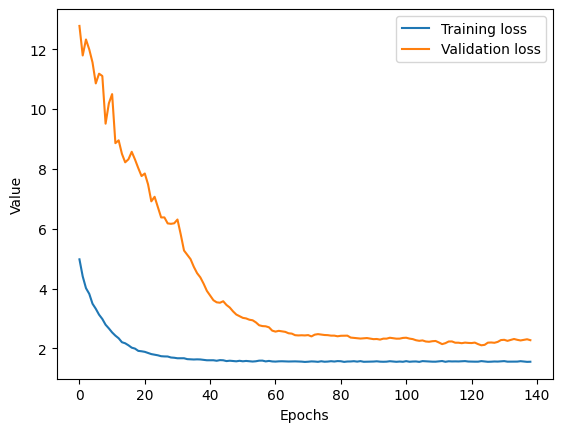

In [609]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

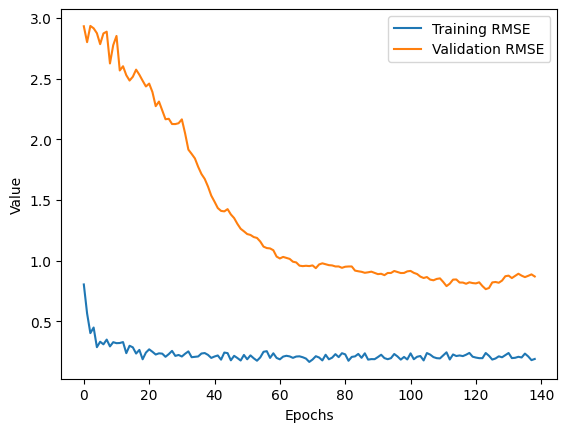

In [610]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

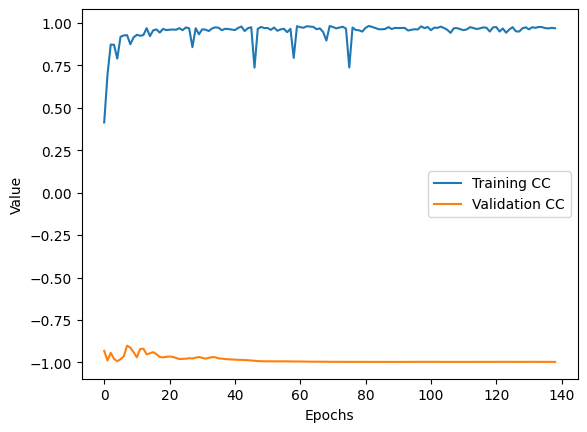

In [611]:
plt.plot(history.history['cc'], label='Training CC')
plt.plot(history.history['val_cc'], label='Validation CC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [612]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = time_model.evaluate(X_train, y_train)

# Make predictions on the test set
y_pred = time_model.predict(X_train)

4/4 [==============================] - 0s 4ms/step


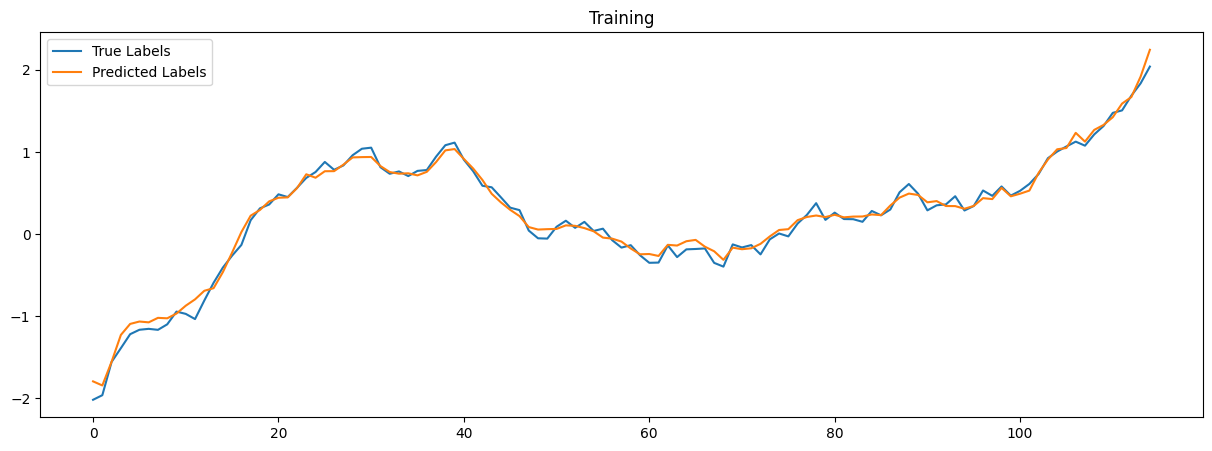

In [613]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.title('Training')
# plt.savefig('training_plot.png') # 輸出圖片成檔案(要放在plt.show()之前否則會輸出空白圖表)
plt.show()

1/1 [==============================] - 0s 18ms/step


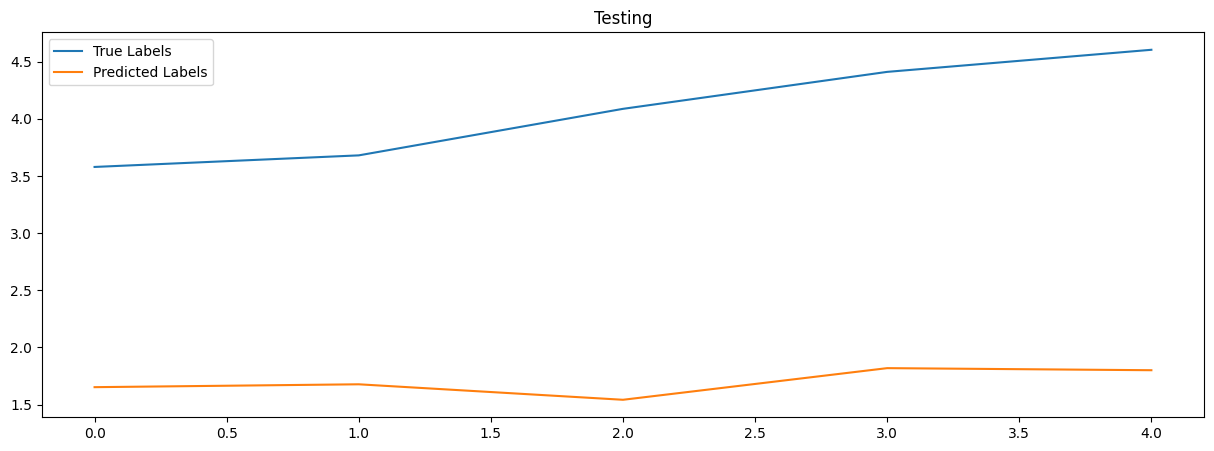

In [614]:
# Evaluate the time_model on the test set
test_loss, test_rmse, test_cc = time_model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred_test = time_model.predict(X_test)

#
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred_test, label='Predicted Labels')
plt.legend()
plt.title('Testing')
plt.show()

5/5 [==============================] - 0s 3ms/step


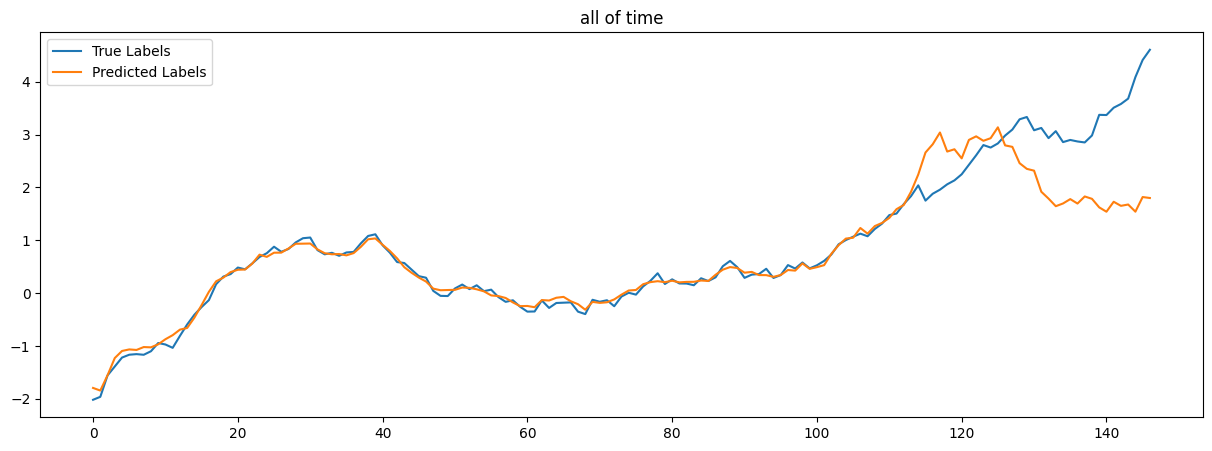

In [615]:
## 全部時間的圖形
# Evaluate the time_model on the test set              # all_data
# test_loss, test_rmse, test_cc = time_model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred_all = time_model.predict(X_all)

#
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_all, label='True Labels')
plt.plot(y_pred_all, label='Predicted Labels')
plt.legend()
plt.title('all of time')
plt.show()

In [616]:
# time_model.save('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/futher_best_time_feature_extraction_model.h5') # 模型的副檔名記得是.h5

In [617]:
# 若模型當中有一些自定義的模塊layer，再載入模型時要使用custom_objects參數以"字典"配對的方式指定
time_model = tf.keras.models.load_model('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/futher_best_time_feature_extraction_model.h5', custom_objects={'CBAMLayer': CBAMLayer, 'cc':cc})

In [112]:
# model_loaded.predict(X_all)

### embedding model of time series
* 提取訓練好的模型中間層，做為新的模型輸出

In [113]:
from tensorflow.keras.models import Model

embedding_time_model = Model(inputs=time_model.input, outputs=time_model.layers[-2].output)

In [114]:
intermediate_output = embedding_time_model.predict(X_test)

1/1 [==============================] - 0s 166ms/step


In [115]:
X_test.shape

(5, 12, 23)

## 分X, y (要先切分test, train, validation，再來分time, non_time)

In [116]:
df = nn_final_df.copy()

In [117]:
df.info(max_cols=382)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757749 entries, 0 to 757748
Data columns (total 382 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    new_per_ping                          757749 non-null  float64
 1    main_building_ratio                   757749 non-null  float64
 2    building_age                          757749 non-null  float64
 3    number_of_land                        757749 non-null  int64  
 4    number_of_building                    757749 non-null  int64  
 5    number_of_parking_space               757749 non-null  int64  
 6    total_area_ping                       757749 non-null  float64
 7    total_floors                          757749 non-null  float64
 8    target_floor                          757749 non-null  float64
 9    transaction_floors                    757749 non-null  float64
 10   bedrooms                              757749 non-null 

In [118]:
# 分特徵與、預測值
y = df['new_per_ping'].values
X = df.drop('new_per_ping', axis=1).values

In [119]:
df.drop('new_per_ping', axis=1)

,main_building_ratio,building_age,number_of_land,number_of_building,number_of_parking_space,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,...,NE0206_lag_12,PA0120_lag_12,PA1205_lag_12,PE0503_lag_12,TSE收盤_lag_12,水泥(TSE11)收盤_lag_12,建材營造(TSE25)收盤_lag_12,航運業(TSE26)收盤_lag_12,鋼鐵(TSE20)收盤_lag_12,預拌混凝土3000磅台北_lag_12
0,100.00,41.000000,1,1,0,20.81,4.0,4.0,1.0,2.0,...,187150.0,94.58,17141.0,80.86,8298.218696,100.47,227.91,67.16,73.13,1900.0
1,86.10,38.000000,2,1,0,32.31,5.0,4.0,1.0,3.0,...,187150.0,94.58,17141.0,80.86,8298.218696,100.47,227.91,67.16,73.13,1900.0
2,49.54,18.000000,1,1,1,10.55,6.0,4.0,1.0,2.0,...,187150.0,94.58,17141.0,80.86,8298.218696,100.47,227.91,67.16,73.13,1900.0
3,72.92,29.000000,1,1,1,61.39,7.0,7.0,1.0,4.0,...,187150.0,94.58,17141.0,80.86,8298.218696,100.47,227.91,67.16,73.13,1900.0
4,51.19,16.761150,1,1,0,17.56,5.0,4.0,1.0,1.0,...,187150.0,94.58,17141.0,80.86,8298.218696,100.47,227.91,67.16,73.13,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757744,74.52,37.000000,1,1,0,19.39,5.0,3.0,1.0,3.0,...,224934.0,98.81,24479.0,94.53,15552.204000,158.90,321.09,85.49,105.10,2025.0
757745,56.89,12.688899,1,1,0,25.97,23.0,3.0,1.0,3.0,...,224934.0,98.81,24479.0,94.53,15552.204000,158.90,321.09,85.49,105.10,2025.0
757746,90.52,36.000000,1,1,0,26.59,5.0,5.0,1.0,2.0,...,224934.0,98.81,24479.0,94.53,15552.204000,158.90,321.09,85.49,105.10,2025.0
757747,43.84,12.688899,1,1,1,47.22,23.0,4.0,1.0,3.0,...,224934.0,98.81,24479.0,94.53,15552.204000,158.90,321.09,85.49,105.10,2025.0


In [120]:
from sklearn.model_selection import train_test_split
# 記得順序要這樣給
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X,y,test_size=0.2, random_state=39)  # 還欠validation set

In [121]:
# 切validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=40)

In [122]:
X_validation.shape

(60620, 381)

In [123]:
# 非時間間的特徵從[0:119], 時間特徵[120:]
# y每一筆資料只有一個值，就不用動了

# train
non_time_train = X_train[:,0:104]
time_series_train = X_train[:,105:] # 119是時間序列月的target_y，就先不要了

# validation
non_time_validation = X_validation[:,0:104]
time_series_validation = X_validation[:,105:]

# test
non_time_test = X_test[:,0:104]
time_series_test = X_test[:,105:]

In [124]:
print(non_time_train.shape)
print(time_series_train.shape)

(545579, 104)
(545579, 276)


## 處理正規化、正則化
* 我知道了non_time就用minmax(這樣特徵就可以保持原樣了...)記先這樣吧
* times就用standardlize

In [125]:
# 非時間特徵用的(這樣one-hot的欄位不受影響，真要要用StandardScaler就要切蘭為了)
from sklearn.preprocessing import MinMaxScaler
mm_scaler_for_non = MinMaxScaler()
non_time_train = mm_scaler_for_non.fit_transform(non_time_train) # 只有訓練資料可以fit，之後都使用訓練資料fit出來的結果作transform
non_time_validation = mm_scaler_for_non.transform(non_time_validation)
non_time_test = mm_scaler_for_non.transform(non_time_train)

# 時間特徵用的
from sklearn.preprocessing import StandardScaler
scaler_for_time = StandardScaler()
time_series_train = scaler_for_time.fit_transform(time_series_train)
time_series_validation = scaler_for_time.transform(time_series_validation)
time_series_test = scaler_for_time.transform(time_series_test)

## 時間相關的模型與特徵處理

In [126]:
# array的處理範例
# arry_index = time_series_train.shape[0]
# each_array = time_series_train[0].reshape(5,36)
# each_array.shape

In [127]:
# 更改成可以餵入ConV1D的形式
# 拿來放要用的資料形式(X:2D)
n_feature = 23
# window_size = 12  ### 注意window_size看上面的定義
arry_index = time_series_train.shape[0] # 抓總筆數
X_shift_list = []

for each_index in range(arry_index):
    # 每一筆資料抓出來
    each_array = time_series_train[each_index].reshape(window_size, n_feature)

    X_shift_list.append(each_array)

In [128]:
# list要轉乘array才可以丟模型
X_times_train = np.array(X_shift_list)
X_times_train.shape

(545579, 12, 23)

In [129]:
arry_index_v = time_series_validation.shape[0] # 抓總筆數   # time_series_validation
X_shift_list_v = []

for each_index in range(arry_index_v):
    # 每一筆資料抓出來
    each_array_v = time_series_validation[each_index].reshape(window_size,n_feature)

    X_shift_list_v.append(each_array_v)

X_times_validation = np.array(X_shift_list_v)
X_times_validation.shape

(60620, 12, 23)

## 非時間特徵模型

In [130]:
feature_shape = non_time_train.shape[1]

In [185]:
# 非時間特徵的模型
# 定義模型層數堆疊 (以class Model建立模型的方式，就只是每一層都有一個輸出，然後下一層繼續接輸出而以)
input_non_time_feature = Input(shape=feature_shape)
y = Dense(64, activation='relu')(input_non_time_feature)
y = BatchNormalization()(y)   # 反正是在layer module中的物件就直接這樣疊
y = Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))(y)
y = BatchNormalization()(y)
y = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))(y)
y = BatchNormalization()(y)
y = Dense(32, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))(y)
y = BatchNormalization()(y)
model_non_time = Model(inputs=input_non_time_feature, outputs=y)

## 幾個epoch就做保存模型的動作，若要繼續續練模型，只需要加載回原先儲存的模型，繼續.fit()就會繼續訓練拉

In [132]:
from tensorflow.keras.callbacks import ModelCheckpoint # 使用此設定每幾個epoch就儲存一次模型
checkpoint_seq = ModelCheckpoint('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/model_new_data_version6_good_time_embedding{epoch:03d}.h5', save_freq='epoch', period=15)
# model_seq_{epoch:03d}.h5這應該是檔名?!        # save_freq=<數值>，表示多少batch儲存一次模型(注意每過一個batch size是一個iteration)，看過全部資料才是一個Epoch
# period有可能不能用，有問題的話注意一下

### 並在模型訓練時透過callbacks參數指定(設定)
# model_seq.fit(X_seq, y_true, epochs=1000, batch_size=32, callbacks=[checkpoint_seq])

## 其他定義
* EarlyStopping
* LearningRateScheduler
* cc(corelation coefficeint) 驗證用

In [133]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)


In [181]:
import math
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    if epoch < 40:
        lr = 0.001
        return lr
    if epoch < 60:
        lr = 0.005
        return lr
    if epoch < 80:
        lr = 0.0001
        return lr
    else:
        return lr * math.exp(-0.1)

lr_Scheduler = LearningRateScheduler(scheduler)

In [135]:
# history = model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_val, y_val),  ## 要這樣給validation set
#     callbacks=[early_stopping, lr_Scheduler, checkpoint_seq]) # keras.callbacks module下的物件，在建立模型時都是以list的形式給的

In [182]:
def cc(y_true, y_pred):
    """
    計算 y_true 和 y_pred 之間的相關係數。
    """
    # 計算協方差矩陣
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # 計算 y_true 和 y_pred 的標準差
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # 計算相關係數
    return cov / (std_true * std_pred)

## concat NNs

In [198]:
from tensorflow.keras.layers import concatenate

# 拼接兩個模型的輸出
combined = concatenate([embedding_time_model.output, model_non_time.output]) # 這是兩個模型concatenate的部分，本來就是要吃兩個模型的output(主要目的是定義"array shape")
z = Dense(64, activation='relu')(combined)
z = BatchNormalization()(z)
z = Dense(64, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(64, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(32, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(32, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(1, activation='linear')(z)  # 假設最後輸出是一個回歸值

# 定義最終的模型
model_combined = Model(inputs=[embedding_time_model.output, model_non_time.input], outputs=z) # 注意這裡的差異，這一個combined model的差異在於他是吃embedding_time_model.output(的形狀)也就是說他並不會訓練到embedding_time_model本身，而是embedding_time_model先去產生他的輸出，再餵到這個combined model模型當中

In [162]:
# embedding_time_model.output (主要目的是定義"array shape")
# >>>
# <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'dense_3')>

In [199]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [200]:
# 編譯模型
model_combined.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError(), cc])

In [156]:
# from tensorflow.keras.optimizers.legacy import Adam

In [157]:
X_times_train.shape

(545579, 12, 23)

In [143]:
# 所以這種做法是，要先利用time embedding model先把時間相關的特徵做embedding，然後等等再當作combined_model的輸入
# 這樣一來就很好的解釋到為什麼embedding_time_model不會隨著combined model一同訓練而是使用原先就訓練好的參數
time_first_embedding_output = embedding_time_model.predict(X_times_train)
time_first_embedding_output_validation = embedding_time_model.predict(X_times_validation)

1895/1895 [==============================] - 4s 2ms/step


In [201]:
history = model_combined.fit([time_first_embedding_output, non_time_train], y_train, epochs=1000, batch_size=64, validation_data=([time_first_embedding_output_validation, non_time_validation], y_validation), callbacks=[checkpoint_seq, lr_Scheduler, early_stopping])

Epoch 1/1000
8525/8525 [==============================] - 50s 5ms/step - loss: 117798854656.0000 - root_mean_squared_error: 343218.3750 - cc: 0.8955 - val_loss: 31212492800.0000 - val_root_mean_squared_error: 176670.5781 - val_cc: 0.8976 - lr: 0.0100
Epoch 2/1000
8525/8525 [==============================] - 45s 5ms/step - loss: 10524186624.0000 - root_mean_squared_error: 102587.4375 - cc: 0.9002 - val_loss: 9143190528.0000 - val_root_mean_squared_error: 95620.0234 - val_cc: 0.8991 - lr: 0.0100
Epoch 3/1000
8525/8525 [==============================] - 44s 5ms/step - loss: 8987541504.0000 - root_mean_squared_error: 94802.6328 - cc: 0.9007 - val_loss: 8884559872.0000 - val_root_mean_squared_error: 94257.9297 - val_cc: 0.8988 - lr: 0.0100
Epoch 4/1000
8525/8525 [==============================] - 45s 5ms/step - loss: 8955924480.0000 - root_mean_squared_error: 94635.7266 - cc: 0.9008 - val_loss: 9120017408.0000 - val_root_mean_squared_error: 95498.7578 - val_cc: 0.8990 - lr: 0.0100
Epoch 5/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8525/8525 [==============================] - 43s 5ms/step - loss: 8899160064.0000 - root_mean_squared_error: 94335.3516 - cc: 0.9015 - val_loss: 9872143360.0000 - val_root_mean_squared_error: 99358.6484 - val_cc: 0.8929 - lr: 0.0100
Epoch 6/1000
8525/8525 [==============================] - 44s 5ms/step - loss: 8913310720.0000 - root_mean_squared_error: 94410.3125 - cc: 0.9015 - val_loss: 145575952384.0000 - val_root_mean_squared_error: 381544.1562 - val_cc: 0.8985 - lr: 0.0100
Epoch 7/1000
8525/8525 [==============================] - 45s 5ms/step - loss: 8879337472.0000 - root_mean_squared_error: 94230.2266 - cc: 0.9014 - val_loss: 8883643392.0000 - val_root_mean_squared_error: 94253.0625 - val_cc: 0.8982 - lr: 0.0100
Epoch 8/1000
8525/8525 [==============================] - 44s 5ms/step - loss: 8843553792.0000 - root_mean_squared_error: 94040.1562 - cc: 0.9020 - val_loss: 9168226304.0000 - val_root_mean_squared_error: 95750.8359 - val_cc: 0.8990 - lr: 0.0100
Epoch 9/1000
8525/8525 [==

KeyboardInterrupt: 

In [145]:
#### 存檔用
# model_combined.save('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/futher_best_model_0628.h5') # 模型的副檔名記得是.h5

In [146]:
# 看每一層的shape
model_combined.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 104)]                0         []                            
                                                                                                  
 dense_26 (Dense)            (None, 64)                   6720      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 64)                   256       ['dense_26[1][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dense_27 (Dense)            (None, 128)                  8320      ['batch_normalization_16

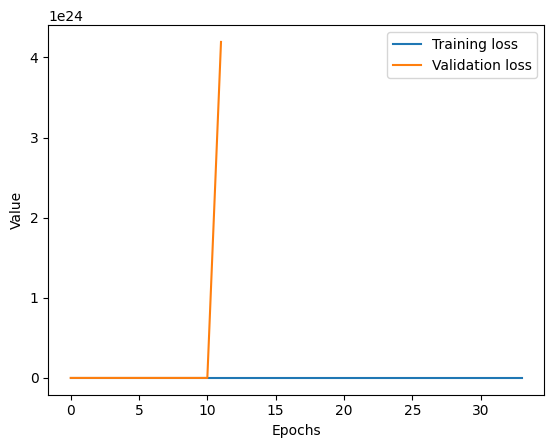

In [147]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

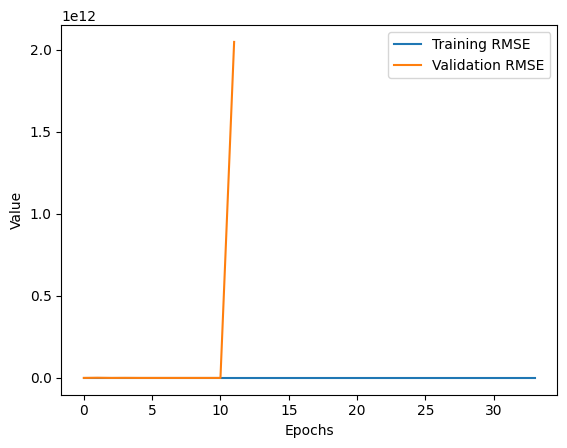

In [148]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## 將模型檔案載入，繼續訓練

In [149]:
# 將模型檔案載入
# model_loaded = tf.keras.models.load_model('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/model_seq_010.h5')

In [150]:
# model_loaded.fit([X_times_train, non_time_train], y_train, epochs=10, batch_size=32, callbacks=[checkpoint_seq])

In [151]:
# model_loaded.save('/content/my_drive/MyDrive/BDSE34期末報告_房價/trained_models/model_save_test.h5') # 模型的副檔名記得是.h5

## 基礎堆疊成功了!!!!!!!